#### Packages

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
class TargetLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, batch_size, device='cpu'):

        np.random.seed(66)
        torch.manual_seed(66)
        
        super(TargetLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.batch_size = batch_size
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        for param in self.parameters():
            nn.init.normal_(param, mean=0.0, std=0.1)
        
        # Initialize on device
        self.to(device)
    
    def load_pytorch_dict_params(self, params_path):
        """
        Load parameters from a PyTorch dictionary format
        """
        with open(params_path, 'rb') as f:
            params = pickle.load(f)
        
        with torch.no_grad():
            # Load embedding weights
            self.embeddings.weight.copy_(params['emb'])
            
            # Load output layer weights
            self.output_layer.weight.copy_(params['out_w'])
            self.output_layer.bias.copy_(params['out_b'])
            
            # Load LSTM weights
            lstm_dict = params['lstm']
            self.lstm.weight_ih_l0.copy_(lstm_dict['weight_ih_l0'])
            self.lstm.weight_hh_l0.copy_(lstm_dict['weight_hh_l0'])
            self.lstm.bias_ih_l0.copy_(lstm_dict['bias_ih_l0'])
            self.lstm.bias_hh_l0.copy_(lstm_dict['bias_hh_l0'])
        
        return self
        
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences
            
    def calculate_nll(self, generated_sequences):

        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Calculate negative log-likelihood
            nll = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1), reduction='mean')
            
            return nll.item()

    def calculate_nll_exact(self, generated_sequences):
        """
        Calculate negative log-likelihood in a way that exactly matches the TensorFlow implementation
        """
        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # One-hot encode targets
            targets_one_hot = F.one_hot(targets, num_classes=self.vocab_size).float()
            
            # Calculate negative log-likelihood exactly like in TensorFlow
            log_probs = torch.log(torch.clamp(probs, min=1e-20))
            nll = -torch.sum(
                targets_one_hot.reshape(-1, self.vocab_size) * 
                log_probs.reshape(-1, self.vocab_size)
            ) / (self.sequence_length * self.batch_size)
            
            return nll.item()

    def save_params(self, path):
        torch.save(self.state_dict(), path)
        
    def load_params(self, path):
        self.load_state_dict(torch.load(path))
        
    def save_samples(self, samples, file_path):
        with open(file_path, 'w') as f:
            for sample in samples.cpu().numpy():
                f.write(' '.join([str(int(x)) for x in sample]) + '\n')
    

In [ ]:
class TestLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, batch_size, device='cpu'):

        np.random.seed(66)
        torch.manual_seed(66)
        
        super(TestLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.batch_size = batch_size
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        for param in self.parameters():
            nn.init.normal_(param, mean=100.0, std=3.1)
        
        # Initialize on device
        self.to(device)
        
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences
            
    def calculate_nll(self, generated_sequences):

        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Calculate negative log-likelihood
            nll = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1), reduction='mean')
            
            return nll.item()

    def calculate_nll_exact(self, generated_sequences):
        """
        Calculate negative log-likelihood in a way that exactly matches the TensorFlow implementation
        """
        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # One-hot encode targets
            targets_one_hot = F.one_hot(targets, num_classes=self.vocab_size).float()
            
            # Calculate negative log-likelihood exactly like in TensorFlow
            log_probs = torch.log(torch.clamp(probs, min=1e-20))
            nll = -torch.sum(
                targets_one_hot.reshape(-1, self.vocab_size) * 
                log_probs.reshape(-1, self.vocab_size)
            ) / (self.sequence_length * self.batch_size)
            
            return nll.item()

    def save_params(self, path):
        torch.save(self.state_dict(), path)
        
    def load_params(self, path):
        self.load_state_dict(torch.load(path))
        
    def save_samples(self, samples, file_path):
        with open(file_path, 'w') as f:
            for sample in samples.cpu().numpy():
                f.write(' '.join([str(int(x)) for x in sample]) + '\n')
    

In [13]:
# Hyperparameters (matching the original implementation)
vocab_size = 5000
embedding_dim = 32
hidden_dim = 32
sequence_length = 20
start_token = 0
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

oracle = TargetLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    sequence_length=sequence_length,
    start_token=start_token,
    batch_size=batch_size,
    device=device
)

test_case = TestLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    sequence_length=sequence_length,
    start_token=start_token,
    batch_size=batch_size,
    device=device
)

In [26]:
num_samples = 1000
oracle_sequences = oracle.generate(num_samples)
test_sequences = test_case.generate(num_samples)


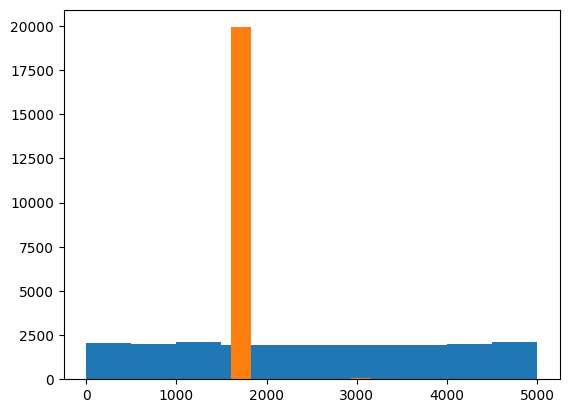

In [27]:
plt.hist(oracle_sequences.flatten(), density=False)
plt.hist(test_sequences.flatten(), density=False)
plt.show()

In [30]:
oracle_nll = oracle.calculate_nll(oracle_sequences)
print(f"\nNLL of oracle-generated sequences: {oracle_nll}")

oracle_nll = oracle.calculate_nll(test_sequences)
print(f"\nNLL of oracle-test sequences: {oracle_nll}")


NLL of oracle-generated sequences: 8.511882781982422

NLL of oracle-test sequences: 8.497983932495117


In [31]:
oracle_nll = test_case.calculate_nll(test_sequences)
print(f"\nNLL of oracle-test sequences: {oracle_nll}")

oracle_nll = test_case.calculate_nll(oracle_sequences)
print(f"\nNLL of oracle-generated sequences: {oracle_nll}")


NLL of oracle-test sequences: 0.024663729593157768

NLL of oracle-generated sequences: 63.696434020996094


In [ ]:
# Generate some sequences using the Oracle


print(f"Generated {num_samples} sequences of length {sequence_length}")
print(f"Sequences shape: {oracle_sequences.shape}")

Generated 1000 sequences of length 20
Sequences shape: torch.Size([1000, 20])


In [6]:
oracle_nll = oracle.calculate_nll(oracle_sequences)
print(f"\nNLL of oracle-generated sequences: {oracle_nll}")


NLL of oracle-generated sequences: 8.512005805969238


In [ ]:
random_sequences = test_case.generate(num_samples)
random_nll = test_case.calculate_nll(oracle_sequences)
#print(f"NLL of random sequences: {random_nll}")
#print(f"Difference: {random_nll - oracle_nll}")

NLL of random sequences: 63.603736877441406
Difference: 55.09173107147217


In [10]:
random_sequences[0:5]

tensor([[1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601,
         1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601],
        [1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601,
         1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601],
        [1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601,
         1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601],
        [1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601,
         1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601],
        [1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601,
         1601, 1601, 1601, 1601, 1601, 1601, 1601, 1601]])

In [ ]:
import pickle
import numpy as np
import os

def analyze_tensorflow_dict_params(pickle_path):
    """
    Load and analyze the TensorFlow parameters from a pickle file when stored as a dictionary.
    
    Args:
        pickle_path: Path to the pickle file containing TensorFlow parameters
        
    Returns:
        A detailed analysis of the parameters
    """
    try:
        # For Python 3 compatibility
        with open(pickle_path, 'rb') as f:
            try:
                params = pickle.load(f)
            except UnicodeDecodeError:
                # If fails, try with encoding specification (for Python 3)
                f.seek(0)
                params = pickle.load(f, encoding='latin1')
    except Exception as e:
        return f"Error loading pickle file: {str(e)}"
    
    if not isinstance(params, dict):
        return f"Unexpected format: params is not a dict, but {type(params)}"
    
    analysis = []
    analysis.append(f"Found {len(params)} parameter entries in dictionary")
    
    # Print all keys
    analysis.append("\nDictionary keys:")
    for key in params.keys():
        analysis.append(f"- {key}")
    
    # Detailed analysis of each parameter
    analysis.append("\nDetailed parameter analysis:")
    for key, value in params.items():
        if isinstance(value, np.ndarray):
            analysis.append(f"{key}: Shape {value.shape}, dtype {value.dtype}, min {value.min():.6f}, max {value.max():.6f}, mean {value.mean():.6f}")
        else:
            analysis.append(f"{key}: Not a numpy array, but {type(value)}")
    
    return "\n".join(analysis)

# Usage example:
# analysis = analyze_tensorflow_dict_params('save/target_params.pkl')
# print(analysis)

In [36]:
#Usage example:
analysis = analyze_tensorflow_dict_params('save/target_params.pkl')
print(analysis)

Found 4 parameter entries in dictionary

Dictionary keys:
- emb
- lstm
- out_w
- out_b

Detailed parameter analysis:
emb: Not a numpy array, but <class 'torch.Tensor'>
lstm: Not a numpy array, but <class 'dict'>
out_w: Not a numpy array, but <class 'torch.Tensor'>
out_b: Not a numpy array, but <class 'torch.Tensor'>


In [37]:
#Usage example:
analysis = analyze_tensorflow_dict_params('save/target_params_py3.pkl')
print(analysis)

Unexpected format: params is not a dict, but <class 'list'>


In [40]:
def analyze_lstm_dict(pickle_path):
    """Analyze the LSTM dictionary in the params"""
    with open(pickle_path, 'rb') as f:
        params = pickle.load(f)
    
    lstm_dict = params['lstm']
    analysis = ["LSTM dictionary contents:"]
    
    for key, value in lstm_dict.items():
        if isinstance(value, torch.Tensor):
            analysis.append(f"{key}: Shape {value.shape}, dtype {value.dtype}, min {value.min().item():.6f}, max {value.max().item():.6f}, mean {value.mean().item():.6f}")
        else:
            analysis.append(f"{key}: Not a tensor, but {type(value)}")
    
    return "\n".join(analysis)

analyze_lstm_dict('save/target_params.pkl')

'LSTM dictionary contents:\nweight_ih_l0: Shape torch.Size([128, 32]), dtype torch.float32, min -0.176717, max 0.176691, mean -0.003182\nweight_hh_l0: Shape torch.Size([128, 32]), dtype torch.float32, min -0.176714, max 0.176738, mean 0.000642\nbias_ih_l0: Shape torch.Size([128]), dtype torch.float32, min -0.167118, max 0.173759, mean 0.007541\nbias_hh_l0: Shape torch.Size([128]), dtype torch.float32, min -0.176697, max 0.173152, mean -0.003580'

In [41]:
def analyze_tensorflow_list_params(pickle_path):
    """Analyze parameters stored as a list"""
    try:
        with open(pickle_path, 'rb') as f:
            try:
                params = pickle.load(f)
            except UnicodeDecodeError:
                f.seek(0)
                params = pickle.load(f, encoding='latin1')
    except Exception as e:
        return f"Error loading pickle file: {str(e)}"
    
    analysis = [f"Found {len(params)} parameter arrays in list"]
    
    for i, param in enumerate(params):
        if isinstance(param, np.ndarray):
            analysis.append(f"Param {i}: Shape {param.shape}, dtype {param.dtype}, min {param.min():.6f}, max {param.max():.6f}, mean {param.mean():.6f}")
        elif isinstance(param, torch.Tensor):
            analysis.append(f"Param {i}: Tensor Shape {param.shape}, dtype {param.dtype}, min {param.min().item():.6f}, max {param.max().item():.6f}, mean {param.mean().item():.6f}")
        else:
            analysis.append(f"Param {i}: Not a numpy array or tensor, but {type(param)}")
    
    return "\n".join(analysis)

analyze_tensorflow_list_params('save/target_params_py3.pkl')

'Found 15 parameter arrays in list\nParam 0: Shape (5000, 32), dtype float32, min -4.714428, max 4.362963, mean 0.004206\nParam 1: Shape (32, 32), dtype float32, min -2.987998, max 3.181021, mean -0.013970\nParam 2: Shape (32, 32), dtype float32, min -3.022867, max 3.097541, mean 0.039178\nParam 3: Shape (32,), dtype float32, min -1.939656, max 1.762500, mean 0.152899\nParam 4: Shape (32, 32), dtype float32, min -3.078522, max 3.077451, mean 0.002182\nParam 5: Shape (32, 32), dtype float32, min -3.510646, max 2.722268, mean 0.000065\nParam 6: Shape (32,), dtype float32, min -1.987712, max 1.900762, mean -0.122108\nParam 7: Shape (32, 32), dtype float32, min -2.970855, max 3.361905, mean 0.014724\nParam 8: Shape (32, 32), dtype float32, min -3.284508, max 3.296018, mean 0.037364\nParam 9: Shape (32,), dtype float32, min -1.274701, max 2.060413, mean 0.463960\nParam 10: Shape (32, 32), dtype float32, min -3.346318, max 2.961451, mean -0.034858\nParam 11: Shape (32, 32), dtype float32, mi